### This is Example 4.3. Gambler’s Problem from Sutton's book.

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. 
If the coin comes up heads, he wins as many dollars as he has staked on that flip; 
if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of $100, 
or loses by running out of money. 

On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars. 
This problem can be formulated as an undiscounted, episodic, finite MDP. 

The state is the gambler’s capital, s ∈ {1, 2, . . . , 99}.
The actions are stakes, a ∈ {0, 1, . . . , min(s, 100 − s)}. 
The reward is zero on all transitions except those on which the gambler reaches his goal, when it is +1.

The state-value function then gives the probability of winning from each state. A policy is a mapping from levels of capital to stakes. The optimal policy maximizes the probability of reaching the goal. Let p_h denote the probability of the coin coming up heads. If p_h is known, then the entire problem is known and it can be solved, for instance, by value iteration.


In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
if "../" not in sys.path:
  sys.path.append("../") 


### Exercise 4.9 (programming)

Implement value iteration for the gambler’s problem and solve it for p_h = 0.25 and p_h = 0.55.

In [7]:
def value_iteration_for_gamblers(p_h, theta=0.0001, discount_factor=1.0):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    rewards = np.zeros(101)
    rewards[100] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros(101)
    
    def one_step_lookahead(s, V, rewards):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(101)
        stakes = range(1, min(s, 100-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        for a in stakes:
            # rewards[s+a], rewards[s-a] are immediate rewards.
            # V[s+a], V[s-a] are values of the next states.
            # This is the core of the Bellman equation: The expected value of your action is 
            # the sum of immediate rewards and the value of the next state.
            A[a] = p_h * (rewards[s+a] + V[s+a]*discount_factor) + (1-p_h) * (rewards[s-a] + V[s-a]*discount_factor)
        return A
    
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(1, 100):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V, rewards)
            # print(s,A,V) # if you want to debug.
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros(100)
    for s in range(1, 100):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V, rewards)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s] = best_action
    # Plotting Final Policy (action stake) vs State (Capital)

    # x axis values
    x = range(100)
    # corresponding y axis values
    y = v[:100]

    # plotting the points 
    plt.plot(x, y)

    # naming the x axis
    plt.xlabel('Capital')
    # naming the y axis
    plt.ylabel('Value Estimates')

    # giving a title to the graph
    plt.title('Final Policy (action stake) vs State (Capital)')

    # function to show the plot
    plt.show()
    
    # Plotting Capital vs Final Policy

    # x axis values
    x = range(100)
    # corresponding y axis values
    y = policy

    # plotting the bars
    plt.bar(x, y, align='center', alpha=0.5)

    # naming the x axis
    plt.xlabel('Capital')
    # naming the y axis
    plt.ylabel('Final policy (stake)')

    # giving a title to the graph
    plt.title('Capital vs Final Policy')

    # function to show the plot
    plt.show()

    return policy, V

In [2]:
def one_step_lookahead(p_h, s, V, rewards,discount_factor):
    """
    Helper function to calculate the value for all action in a given state.

    Args:
        s: The gambler’s capital. Integer.
        V: The vector that contains values at each state. 
        rewards: The reward vector.

    Returns:
        A vector containing the expected value of each action. 
        Its length equals to the number of actions.
    """
    A = np.zeros(101)
    stakes = range(1, min(s, 100-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
    for a in stakes:
        # rewards[s+a], rewards[s-a] are immediate rewards.
        # V[s+a], V[s-a] are values of the next states.
        # This is the core of the Bellman equation: The expected value of your action is 
        # the sum of immediate rewards and the value of the next state.
        A[a] = p_h * (rewards[s+a] + V[s+a]*discount_factor) + (1-p_h) * (rewards[s-a] + V[s-a]*discount_factor)
    return A

In [3]:
# Taken from Policy Evaluation Exercise!

def policy_eval(p_h, rewards, discount_factor=0.01, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(101)
    it = 0
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(1, 100):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(p_h, s, V, rewards, discount_factor)
            #print(s,A,V) # if you want to debug.
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        print ("CURRENT DELTA")
        print (delta)
        if delta < theta:
            break
    return np.array(V)

In [4]:
def policy_iteration_for_gamblers(p_h, theta=0.0001, discount_factor=1.0):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    rewards = np.zeros(101)
    rewards[100] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros(101)
    
    
    policy = np.zeros(100)
    while True:
        # Evaluate the curent policy
        V = policy_eval(p_h, rewards, discount_factor, theta)
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        for s in range(1, 100):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            action_values = one_step_lookahead(p_h, s, V, rewards,discount_factor)
            print("BEST ACTION")

            best_a = np.argmax(action_values)
            print (best_a)
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = best_a
        if policy_stable:
            return policy, V

### Show your results graphically, as in Figure 4.3.


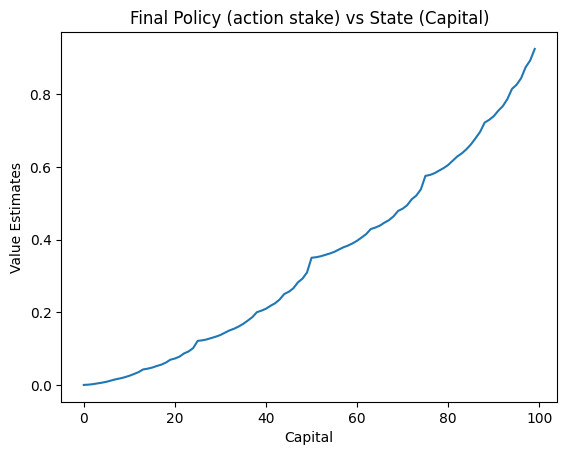

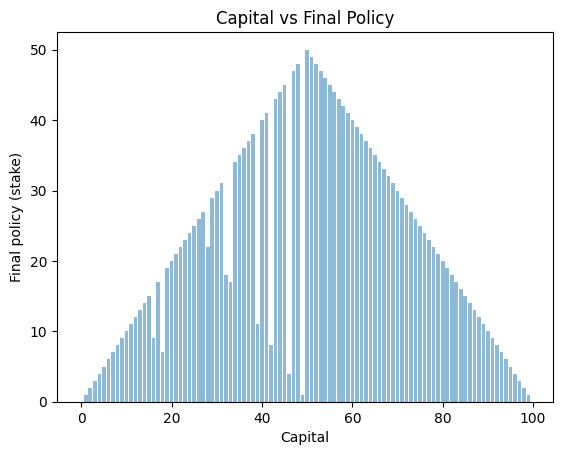

In [14]:
policy, v = value_iteration_for_gamblers(0.35, theta=0.0001, discount_factor=0.99)

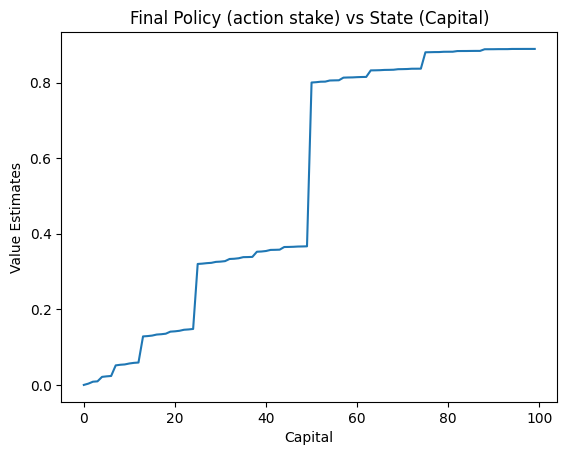

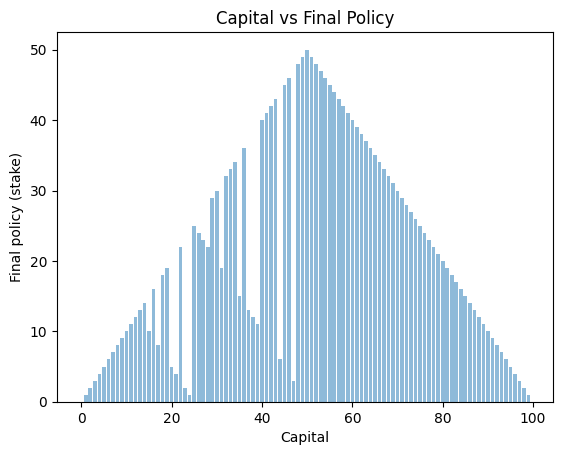

In [25]:
policy, v = value_iteration_for_gamblers(0.4, theta=0.0001, discount_factor=0.5)